In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib

# Configurações globais
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# --- Funções de Pré-processamento ---
def map_categorical_columns(df, mapping_dicts):
    """
    Aplica mapeamentos a colunas categóricas do DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        mapping_dicts (dict): Dicionário com mapeamentos para cada coluna categórica.
    
    Returns:
        pd.DataFrame: DataFrame com colunas mapeadas.
    """
    df_mapped = df.copy()
    for col, mapping in mapping_dicts.items():
        df_mapped[col] = df_mapped[col].map(mapping)
        if df_mapped[col].isnull().any():
            print(f"Aviso: Valores nulos encontrados em {col} após mapeamento.")
    return df_mapped

def preprocess_data(df, mapping_dicts):
    """
    Realiza o pré-processamento, mapeando valores categóricos.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        mapping_dicts (dict): Dicionário com mapeamentos para cada coluna categórica.
    
    Returns:
        pd.DataFrame: DataFrame pré-processado.
    """
    df_mapped = map_categorical_columns(df, mapping_dicts)
    return df_mapped

# --- Função de Análise Exploratória de Dados (EDA) ---
def exploratory_data_analysis(df, numeric_cols, categorical_cols, target='Risk'):
    """
    Realiza análise exploratória de dados com visualizações.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        numeric_cols (list): Lista de colunas numéricas.
        categorical_cols (list): Lista de colunas categóricas.
        target (str): Nome da variável alvo.
    """
    print("1. Distribuições Numéricas")
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=df, x=col, hue=target, multiple='stack', palette={0: "green", 1: "red"})
        plt.title(f'Distribuição de {col}')
    plt.tight_layout()
    plt.show()

    print("2. Distribuições Categóricas")
    for col in categorical_cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col, hue=target, palette={0: "green", 1: "red"})
        plt.title(f'Distribuição de {col} por {target}')
        plt.xticks(rotation=45)
        plt.legend(title='Risco', labels=['Bom (0)', 'Mau (1)'])
        plt.show()

    print("3. Correlação com Target (Variáveis Numéricas)")
    correlations = df[numeric_cols + [target]].corr()[target].sort_values()
    plt.figure(figsize=(10, 6))
    correlations.drop(target).plot(kind='barh', color='skyblue')
    plt.title(f'Correlação das Features Numéricas com {target}')
    plt.show()

# --- Funções de Treinamento e Avaliação ---
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Treina e avalia um modelo, exibindo métricas e matriz de confusão.
    
    Args:
        model: Modelo de machine learning.
        X_train, X_test, y_train, y_test: Dados de treino e teste.
        model_name (str): Nome do modelo para exibição.
    
    Returns:
        tuple: Previsões, acurácia e custo total.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
    total_cost = FN * 5 + FP * 1
    
    # Relatório
    print(f"\n===== Relatório de Desempenho do {model_name} =====")
    print(f"Acurácia: {accuracy*100:.2f}%")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Bom Risco (0)', 'Mau Risco (1)']))
    
    # Matriz de Confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Previu Bom (0)', 'Previu Mau (1)'],
                yticklabels=['Real Bom (0)', 'Real Mau (1)'])
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Previsão do Modelo')
    plt.ylabel('Valor Real')
    plt.show()
    
    print(f"Falsos Negativos (FN): {FN}, Falsos Positivos (FP): {FP}, Custo Total: {total_cost}")
    return y_pred, accuracy, total_cost

def plot_roc_curve(model, X_test, y_test, model_name):
    """
    Plota a curva ROC do modelo.
    
    Args:
        model: Modelo treinado.
        X_test, y_test: Dados de teste.
        model_name (str): Nome do modelo.
    """
    if hasattr(model.named_steps['classifier'], 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend()
        plt.show()
        return roc_auc
    else:
        print(f"{model_name} não suporta predict_proba.")
        return None

# --- Otimização de Limiar para Custo ---
def optimize_threshold_for_cost(model, X_test, y_test, thresholds, model_name):
    """
    Otimiza o limiar de classificação para minimizar o custo (FN * 5 + FP * 1).
    
    Args:
        model: Modelo treinado.
        X_test: Dados de teste.
        y_test: Rótulos verdadeiros.
        thresholds: Lista de limiares a testar.
        model_name: Nome do modelo para exibição.
    
    Returns:
        tuple: Melhor limiar, menor custo, métricas associadas.
    """
    best_threshold = None
    min_cost = float('inf')
    best_metrics = None
    
    if hasattr(model.named_steps.get('classifier'), 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            conf_matrix = confusion_matrix(y_test, y_pred)
            TN, FP, FN, TP = conf_matrix.ravel()
            total_cost = FN * 5 + FP * 1
            accuracy = accuracy_score(y_test, y_pred)
            
            if total_cost < min_cost:
                min_cost = total_cost
                best_threshold = threshold
                best_metrics = {
                    'accuracy': accuracy,
                    'confusion_matrix': conf_matrix,
                    'classification_report': classification_report(y_test, y_pred, target_names=['Bom Risco (0)', 'Mau Risco (1)'], output_dict=True)
                }
            
            # Exibir resultados para cada limiar
            print(f"\nLimiar: {threshold:.2f}")
            print(f"Custo Total: {total_cost}")
            print(f"Acurácia: {accuracy*100:.2f}%")
            print("Matriz de Confusão:")
            print(conf_matrix)
        
        # Exibir resultados do melhor limiar
        if best_threshold is not None:
            print(f"\n===== Melhor Limiar para {model_name} =====")
            print(f"Melhor Limiar: {best_threshold:.2f}")
            print(f"Menor Custo: {min_cost}")
            print(f"Acurácia: {best_metrics['accuracy']*100:.2f}%")
            print("\nRelatório de Classificação:")
            print(best_metrics['classification_report'])
            plt.figure(figsize=(8, 6))
            sns.heatmap(best_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Previu Bom (0)', 'Previu Mau (1)'],
                        yticklabels=['Real Bom (0)', 'Real Mau (1)'])
            plt.title(f'Matriz de Confusão - {model_name} (Limiar = {best_threshold:.2f})')
            plt.xlabel('Previsão do Modelo')
            plt.ylabel('Valor Real')
            plt.show()
        
        return best_threshold, min_cost, best_metrics
    else:
        print(f"{model_name} não suporta predict_proba.")
        return None, None, None

In [3]:
# --- Carregamento e Pré-processamento dos Dados ---
data = pd.read_csv(
    r'../data/german.data', 
    sep=r'\s+', header=None
)
df = data.copy()

# Renomear colunas
new_column_names = {
    0: 'Checking_Account_Status', 1: 'Duration_in_months', 2: 'Credit_History', 3: 'Purpose',
    4: 'Credit_Amount', 5: 'Saving_Account_Bonds', 6: 'Present_Employment_Since', 7: 'Installment_Rate',
    8: 'Personal_Status_Sex', 9: 'Other_Debtors_Guarantors', 10: 'Present_Residence_Since', 
    11: 'Property', 12: 'Age', 13: 'Other_Installment_Plans', 14: 'Housing', 15: 'Number_of_Credits',
    16: 'Job', 17: 'People_Liable_for_Maintenance', 18: 'Telephone', 19: 'Foreign_worker', 20: 'Risk'
}
df = df.rename(columns=new_column_names)

# Mapear a variável alvo
df['Risk'] = df['Risk'].map({2: 1, 1: 0})

# Definir colunas numéricas e categóricas
numeric_cols = ['Duration_in_months', 'Credit_Amount', 'Installment_Rate', 'Age', 
                'Present_Residence_Since', 'Number_of_Credits']
categorical_cols = ['Checking_Account_Status', 'Credit_History', 'Purpose', 'Saving_Account_Bonds', 
                    'Present_Employment_Since', 'Personal_Status_Sex', 'Other_Debtors_Guarantors', 
                    'Property', 'Other_Installment_Plans', 'Housing', 'Job', 'Telephone', 
                    'Foreign_worker', 'People_Liable_for_Maintenance']

# Mapeamentos categóricos para EDA
mapping_dicts = {
    'Checking_Account_Status': {
        'A11': 'less than 0 DM',
        'A12': '0 to 200 DM',
        'A13': 'over 200 DM / 1 year salary',
        'A14': 'no checking account'
    },
    'Credit_History': {
        'A30': 'no credits/all paid duly',
        'A31': 'all paid duly at this bank',
        'A32': 'existing paid duly',
        'A33': 'delay in the past',
        'A34': 'critical account/other credits'
    },
    'Purpose': {
        'A40': 'car (new)', 'A41': 'car (used)', 'A42': 'furniture/equipment',
        'A43': 'radio/television', 'A44': 'domestic appliances', 'A45': 'repairs',
        'A46': 'education', 'A48': 'retraining', 'A49': 'business', 'A410': 'others'
    },
    'Saving_Account_Bonds': {
        'A61': 'less than 100 DM', 'A62': '100 to 500 DM', 'A63': '500 to 1000 DM',
        'A64': 'over 1000 DM', 'A65': 'unknown/ no savings account'
    },
    'Present_Employment_Since': {
        'A71': 'unemployed', 'A72': 'less than 1 year', 'A73': '1 to 4 years',
        'A74': '4 to 7 years', 'A75': 'over 7 years'
    },
    'Personal_Status_Sex': {
        'A91': 'Male: divorced/separated', 'A92': 'Female: divorced/separated/married',
        'A93': 'Male: single', 'A94': 'Male: married/widowed', 'A95': 'Female: single'
    },
    'Other_Debtors_Guarantors': {
        'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor'
    },
    'Property': {
        'A121': 'real estate', 'A122': 'building savings/life insurance',
        'A123': 'car or other', 'A124': 'unknown/no property'
    },
    'Other_Installment_Plans': {
        'A141': 'bank', 'A142': 'stores', 'A143': 'none'
    },
    'Housing': {
        'A151': 'rent', 'A152': 'own', 'A153': 'for free'
    },
    'Job': {
        'A171': 'unemployed/unskilled non-resident', 'A172': 'unskilled resident',
        'A173': 'skilled employee/official', 'A174': 'management/self-employed/highly qualified'
    },
    'Telephone': {
        'A191': 'none', 'A192': 'yes, registered under the customers name'
    },
    'Foreign_worker': {
        'A201': 'yes', 'A202': 'no'
    },
    'People_Liable_for_Maintenance': {
        1: '0 to 2 people', 2: '3 or more people'
    }
}

# Criar DataFrame para EDA com valores legíveis
df_mapped = preprocess_data(df, mapping_dicts)
print("\nValores nulos por coluna (EDA):")
print(df_mapped.isnull().sum())


Valores nulos por coluna (EDA):
Checking_Account_Status          0
Duration_in_months               0
Credit_History                   0
Purpose                          0
Credit_Amount                    0
Saving_Account_Bonds             0
Present_Employment_Since         0
Installment_Rate                 0
Personal_Status_Sex              0
Other_Debtors_Guarantors         0
Present_Residence_Since          0
Property                         0
Age                              0
Other_Installment_Plans          0
Housing                          0
Number_of_Credits                0
Job                              0
People_Liable_for_Maintenance    0
Telephone                        0
Foreign_worker                   0
Risk                             0
dtype: int64



===== Análise Exploratória de Dados =====
1. Distribuições Numéricas


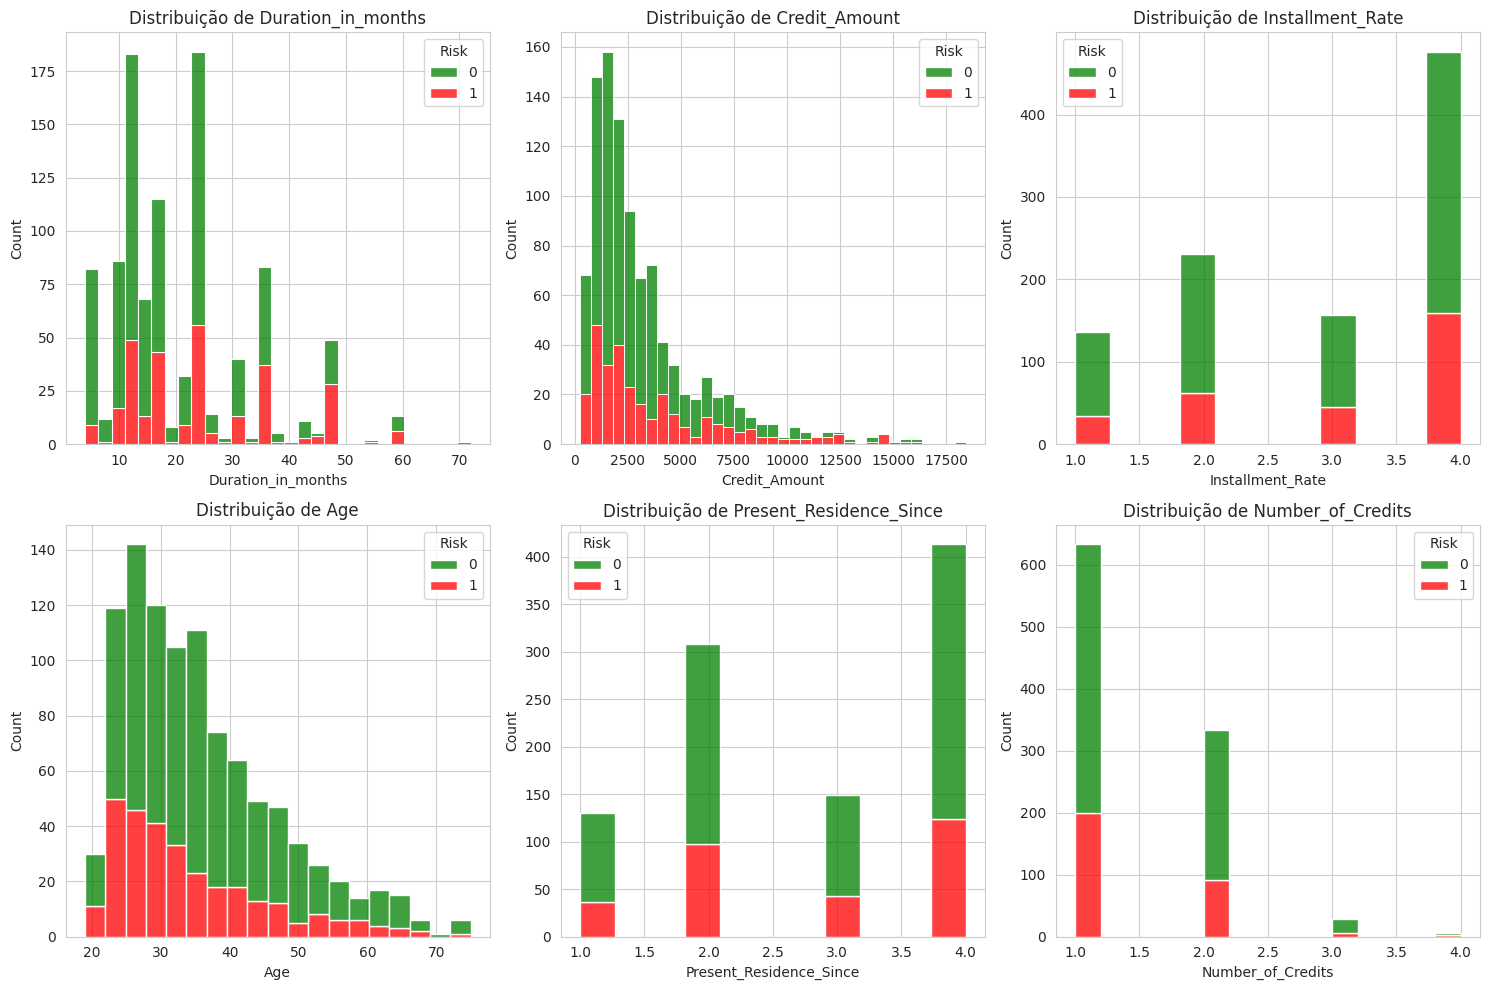

2. Distribuições Categóricas


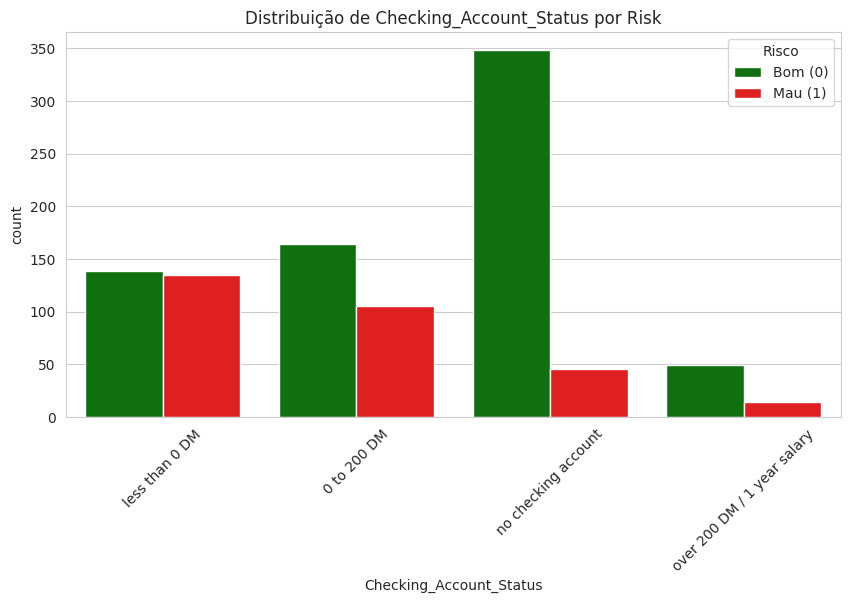

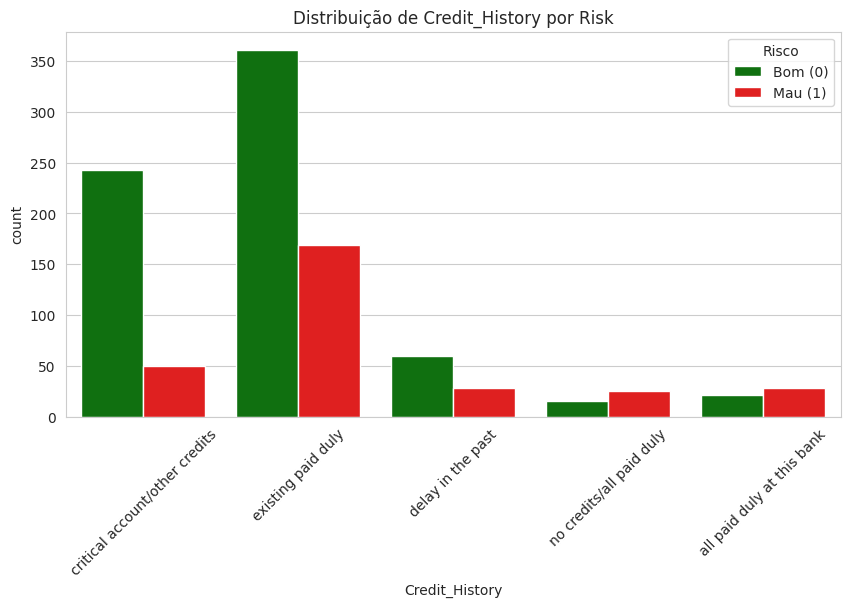

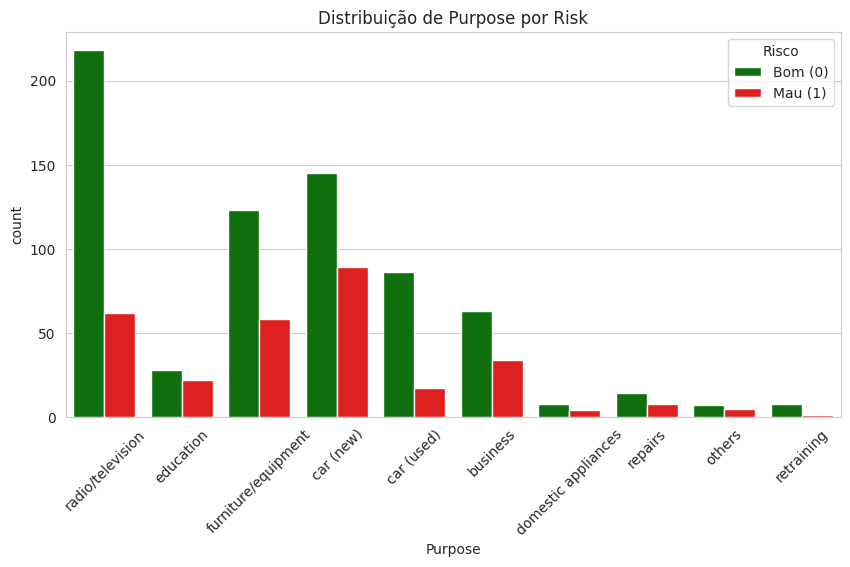

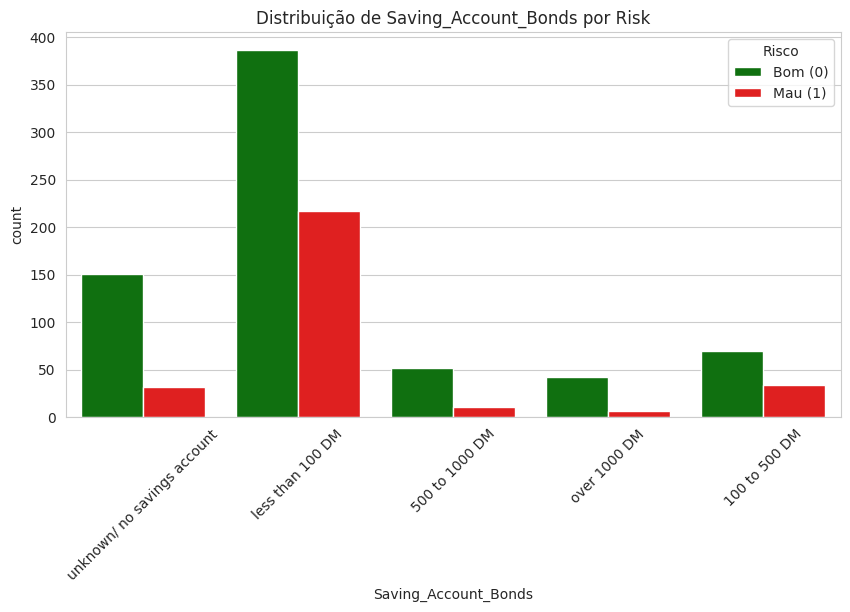

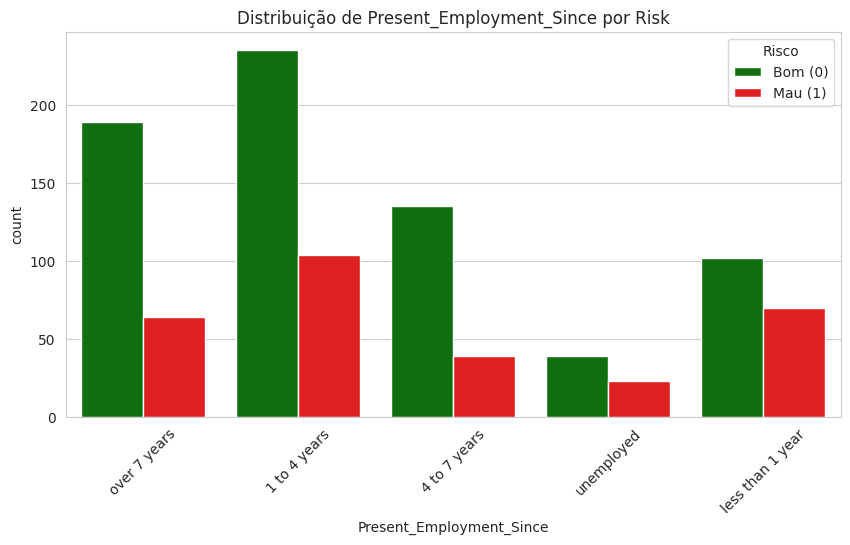

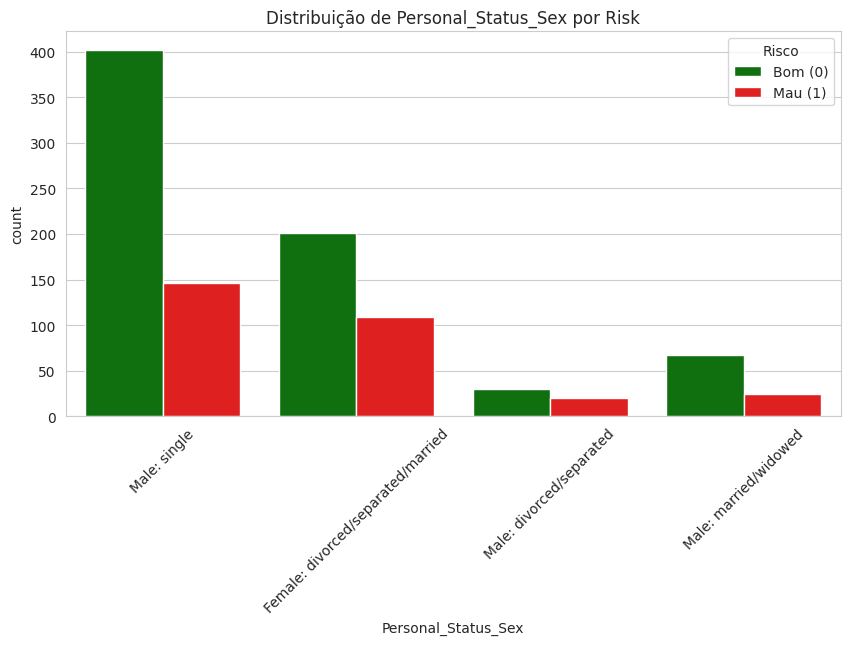

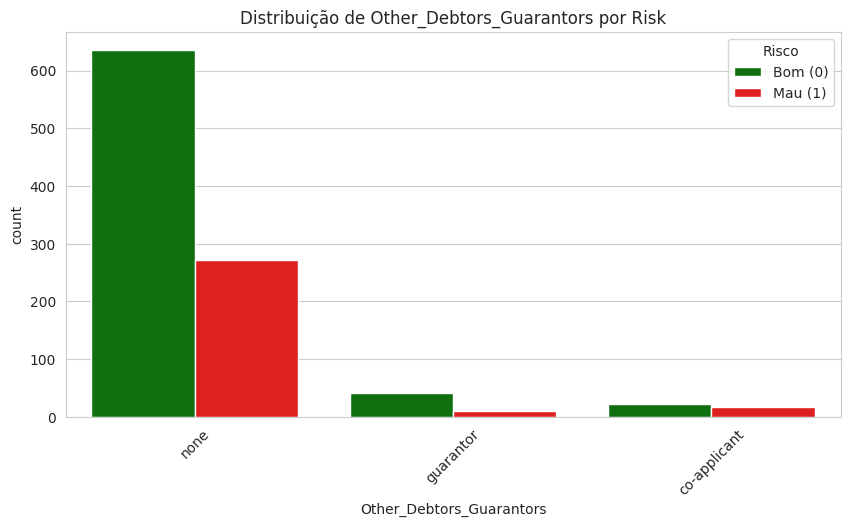

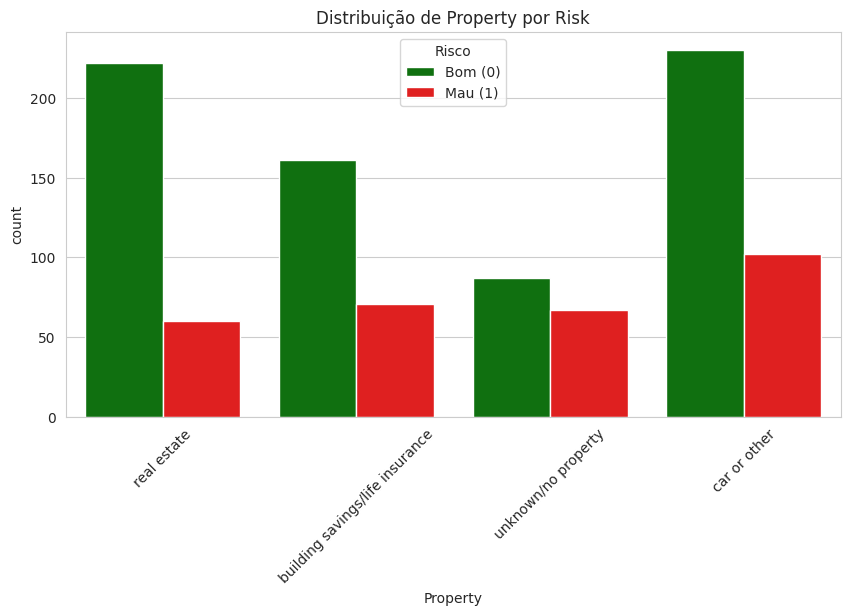

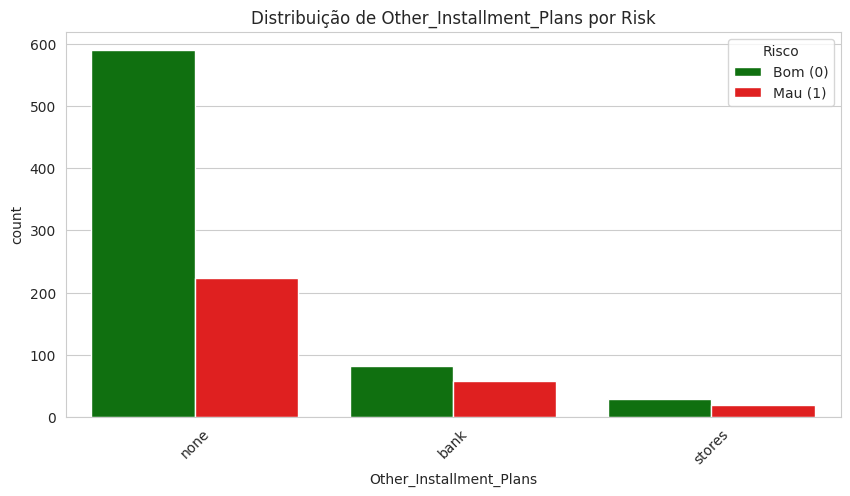

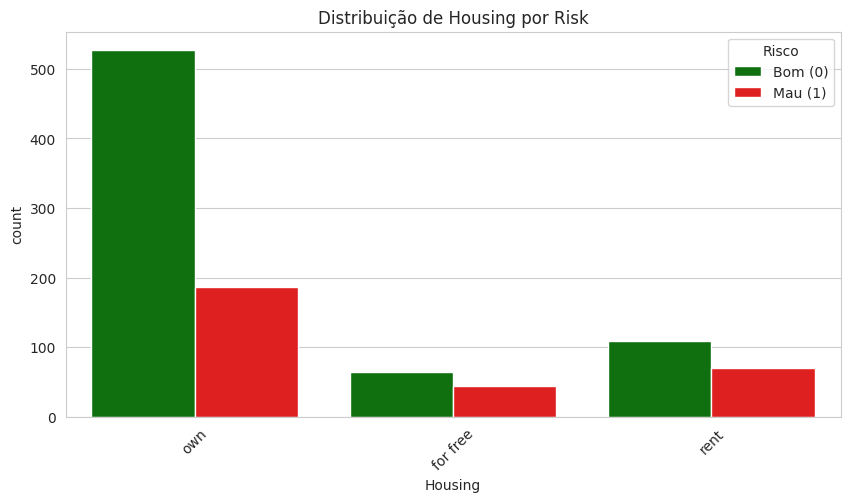

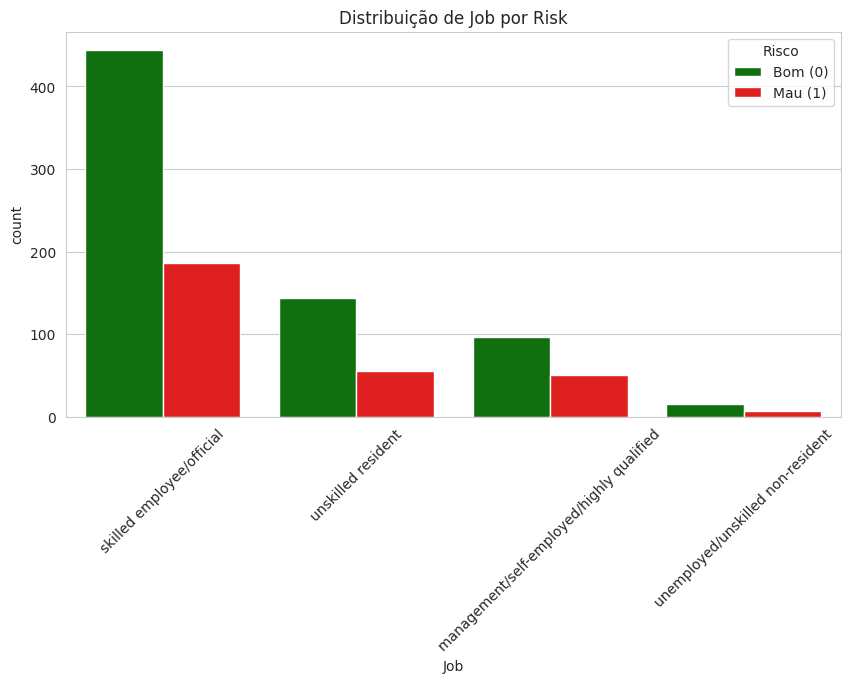

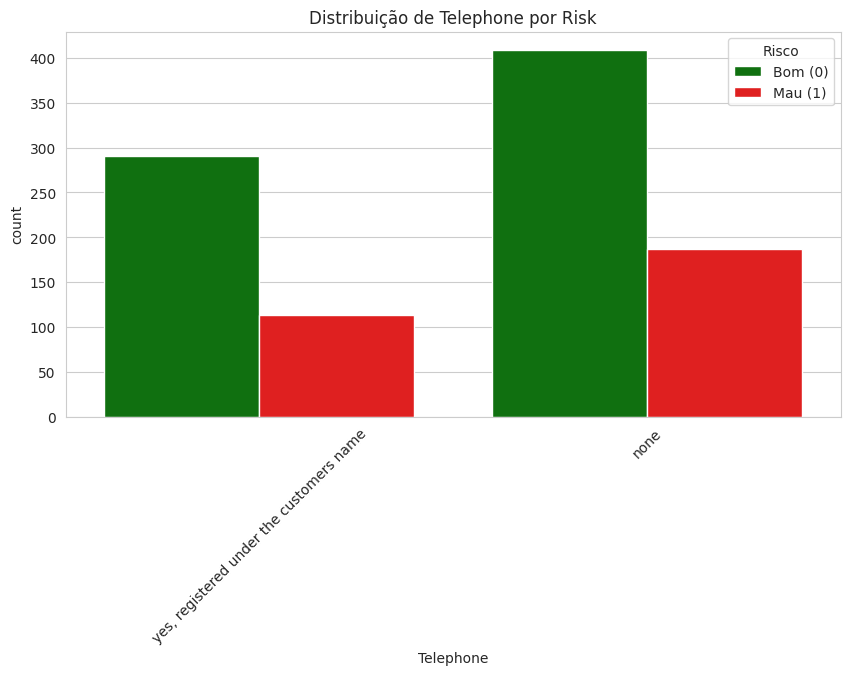

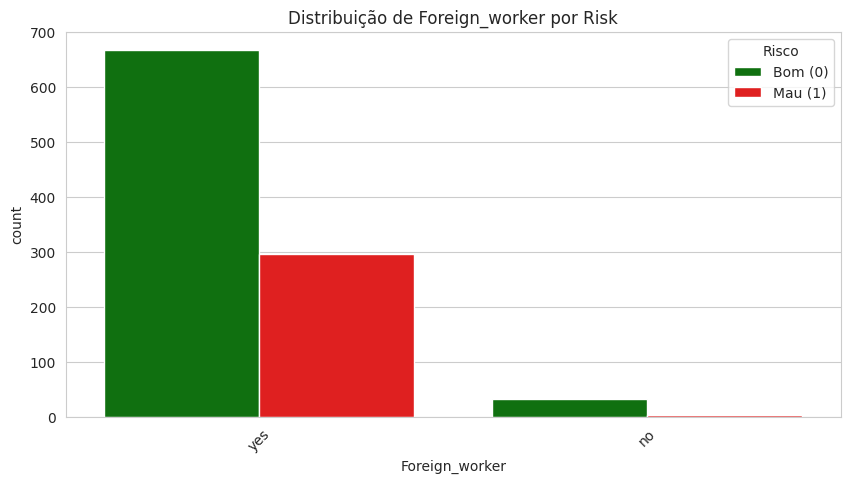

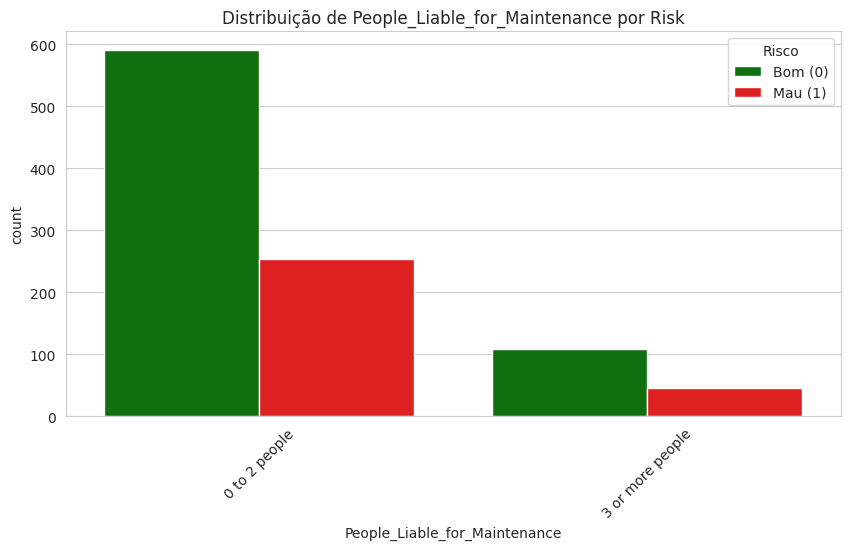

3. Correlação com Target (Variáveis Numéricas)


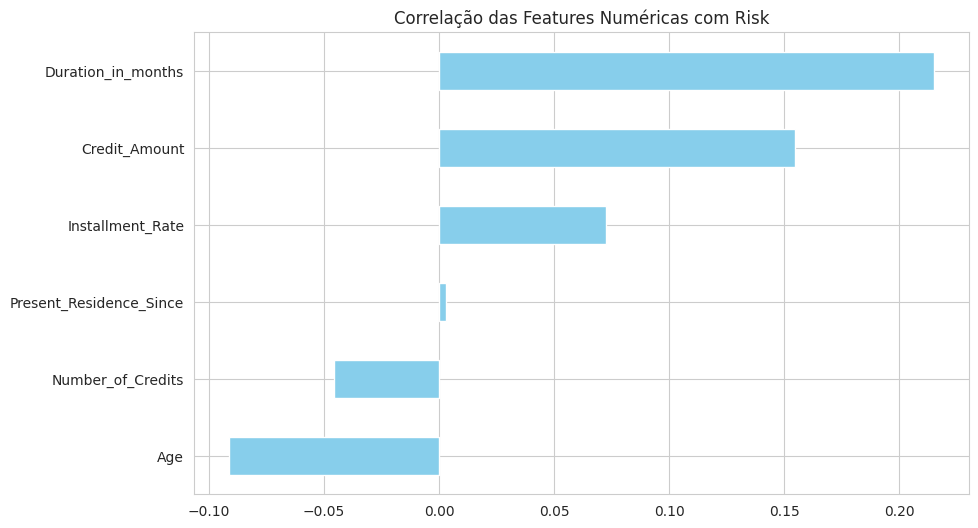

In [4]:
# --- Análise Exploratória de Dados ---
print("\n===== Análise Exploratória de Dados =====")
exploratory_data_analysis(df_mapped, numeric_cols, categorical_cols)

In [5]:
# --- Divisão dos Dados ---
X = df_mapped.drop('Risk', axis=1)
y = df_mapped['Risk']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Shape de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}, y_test: {y_test.shape}")

# --- Pipeline de Pré-processamento ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

Shape de X_train: (700, 20), X_test: (300, 20)
Shape de y_train: (700,), y_test: (300,)



===== Avaliação do Logistic Regression =====

===== Relatório de Desempenho do Logistic Regression =====
Acurácia: 78.33%

Relatório de Classificação:
               precision    recall  f1-score   support

Bom Risco (0)       0.82      0.89      0.85       210
Mau Risco (1)       0.68      0.53      0.60        90

     accuracy                           0.78       300
    macro avg       0.75      0.71      0.72       300
 weighted avg       0.77      0.78      0.78       300



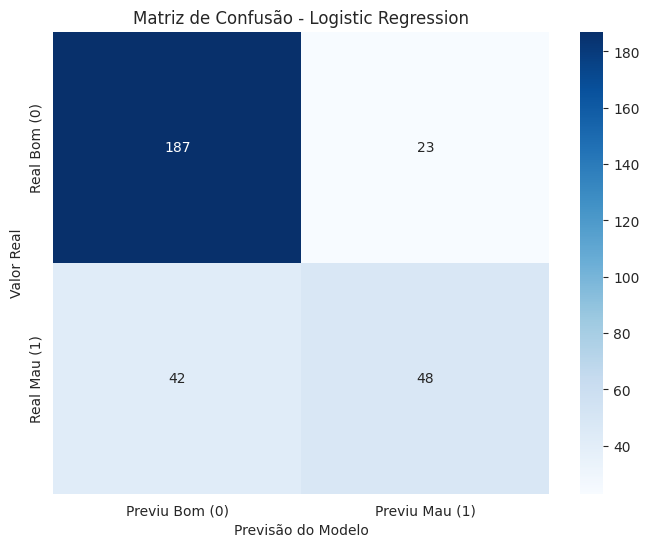

Falsos Negativos (FN): 42, Falsos Positivos (FP): 23, Custo Total: 233


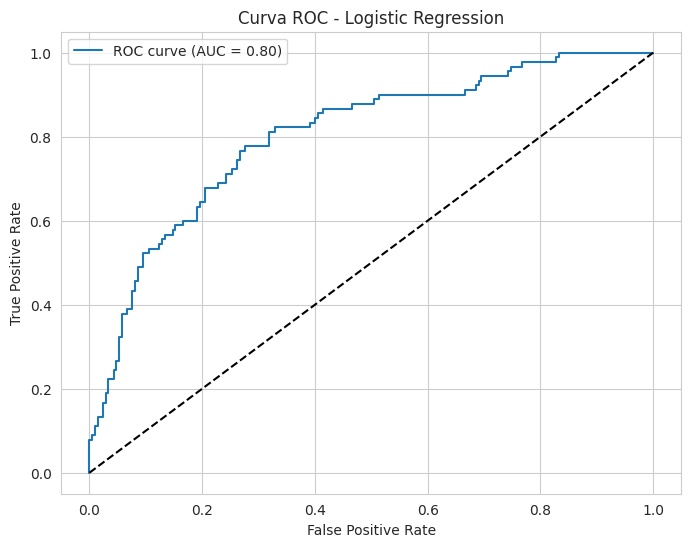


===== Avaliação do Random Forest =====

===== Relatório de Desempenho do Random Forest =====
Acurácia: 75.67%

Relatório de Classificação:
               precision    recall  f1-score   support

Bom Risco (0)       0.78      0.91      0.84       210
Mau Risco (1)       0.66      0.39      0.49        90

     accuracy                           0.76       300
    macro avg       0.72      0.65      0.66       300
 weighted avg       0.74      0.76      0.74       300



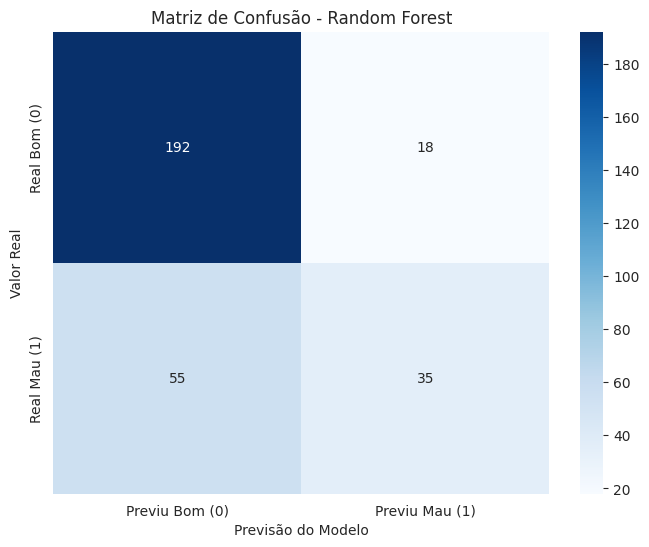

Falsos Negativos (FN): 55, Falsos Positivos (FP): 18, Custo Total: 293


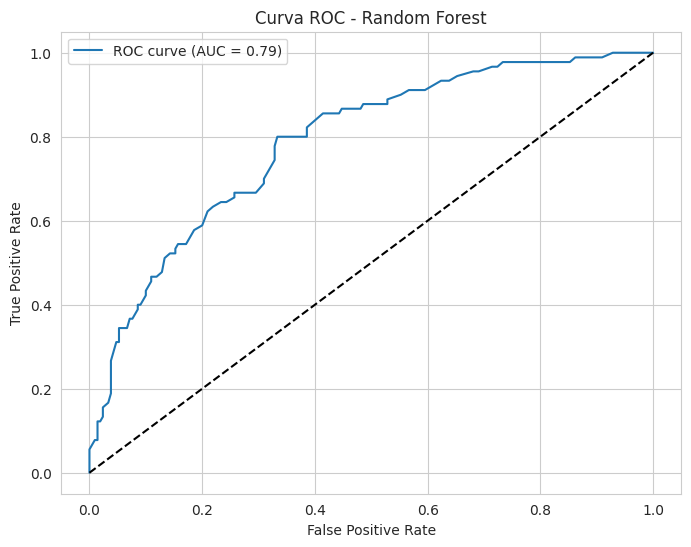


===== Avaliação do Random Forest Weighted =====

===== Relatório de Desempenho do Random Forest Weighted =====
Acurácia: 76.00%

Relatório de Classificação:
               precision    recall  f1-score   support

Bom Risco (0)       0.78      0.92      0.84       210
Mau Risco (1)       0.68      0.38      0.49        90

     accuracy                           0.76       300
    macro avg       0.73      0.65      0.66       300
 weighted avg       0.75      0.76      0.74       300



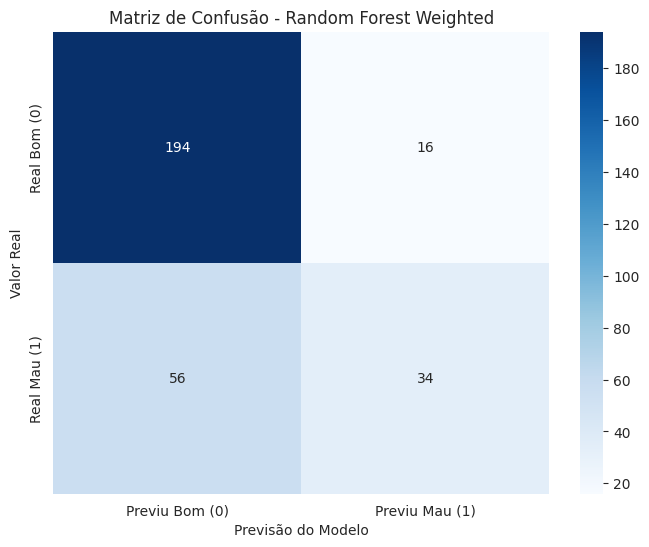

Falsos Negativos (FN): 56, Falsos Positivos (FP): 16, Custo Total: 296


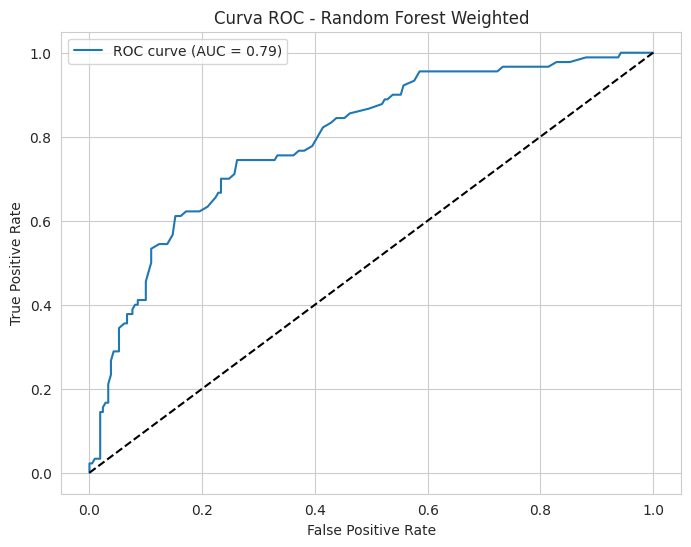


===== Avaliação do XGBoost =====

===== Relatório de Desempenho do XGBoost =====
Acurácia: 72.67%

Relatório de Classificação:
               precision    recall  f1-score   support

Bom Risco (0)       0.79      0.82      0.81       210
Mau Risco (1)       0.55      0.50      0.52        90

     accuracy                           0.73       300
    macro avg       0.67      0.66      0.67       300
 weighted avg       0.72      0.73      0.72       300



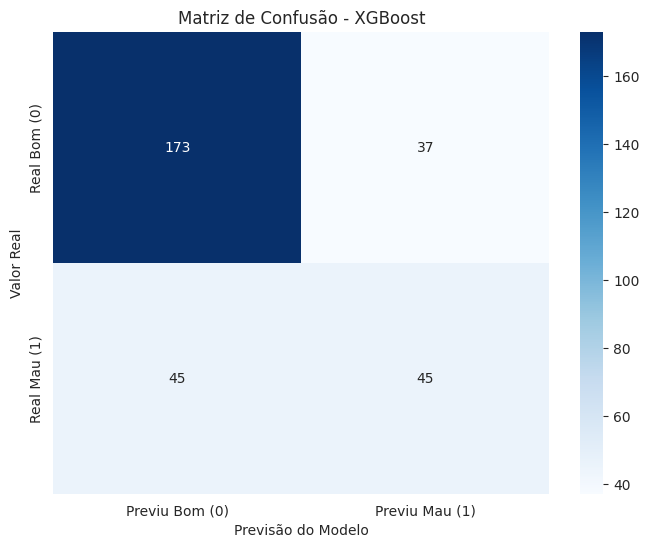

Falsos Negativos (FN): 45, Falsos Positivos (FP): 37, Custo Total: 262


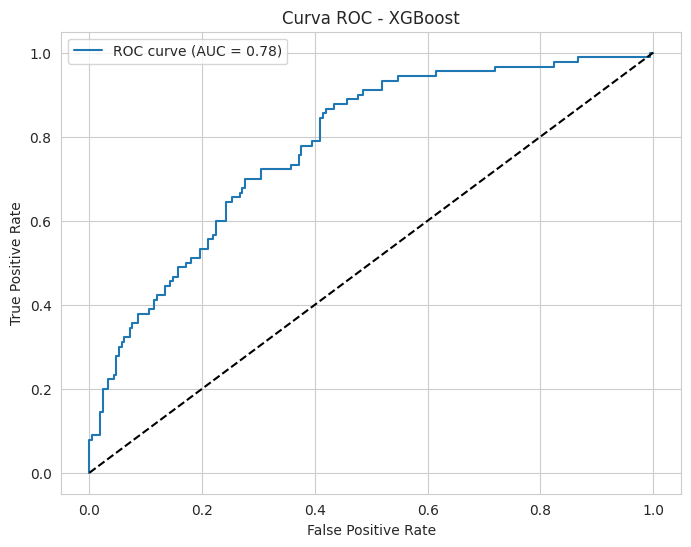

In [6]:
# --- Treinamento e Avaliação dos Modelos ---
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    'Random Forest Weighted': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, class_weight={0: 1, 1: 5}))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), random_state=42))
    ])
}

results = []
for model_name, model in models.items():
    print(f"\n===== Avaliação do {model_name} =====")
    y_pred, accuracy, total_cost = train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    roc_auc = plot_roc_curve(model, X_test, y_test, model_name)
    results.append({'Modelo': model_name, 'Acurácia': accuracy, 'Custo Total': total_cost, 'AUC-ROC': roc_auc})



===== Random Forest com SMOTE =====

===== Relatório de Desempenho do Random Forest SMOTE =====
Acurácia: 76.67%

Relatório de Classificação:
               precision    recall  f1-score   support

Bom Risco (0)       0.79      0.90      0.84       210
Mau Risco (1)       0.67      0.44      0.53        90

     accuracy                           0.77       300
    macro avg       0.73      0.67      0.69       300
 weighted avg       0.75      0.77      0.75       300



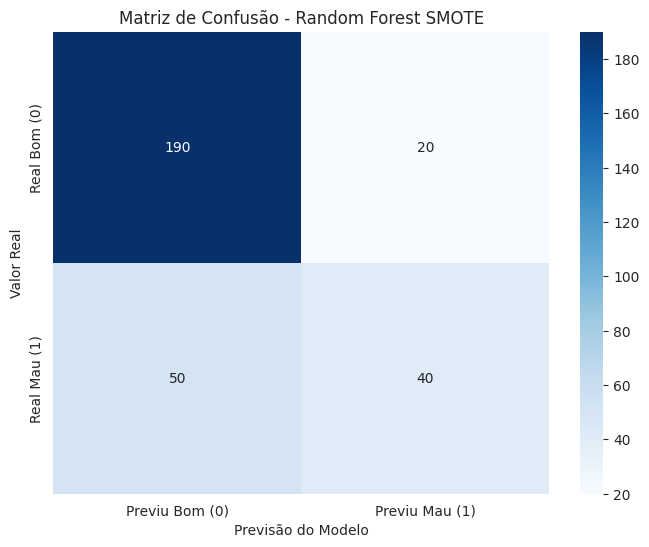

Falsos Negativos (FN): 50, Falsos Positivos (FP): 20, Custo Total: 270


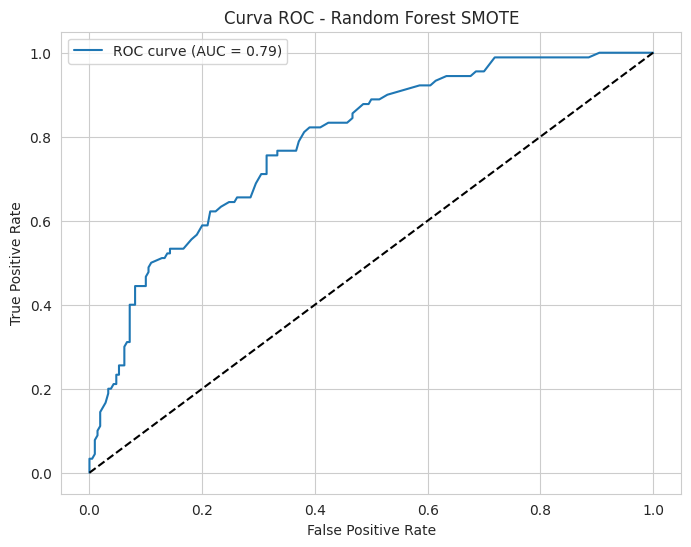

In [7]:
# --- Random Forest com SMOTE ---
print("\n===== Random Forest com SMOTE =====")
smote = SMOTE(random_state=42)

# Transformar X_train e X_test em arrays numéricos antes do SMOTE
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)

# Aplicar SMOTE ao conjunto de treino numérico
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

# Criar pipeline sem preprocessor, pois os dados já foram transformados
model_rf_smote = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Avaliar o modelo
y_pred, accuracy, total_cost = train_and_evaluate_model(
    model_rf_smote, X_train_balanced, X_test_transformed, y_train_balanced, y_test, 'Random Forest SMOTE'
)
roc_auc = plot_roc_curve(model_rf_smote, X_test_transformed, y_test, 'Random Forest SMOTE')
results.append({'Modelo': 'Random Forest SMOTE', 'Acurácia': accuracy, 'Custo Total': total_cost, 'AUC-ROC': roc_auc})



===== Otimização de Limiar para Random Forest Ponderado =====

Limiar: 0.25
Custo Total: 175
Acurácia: 65.67%
Matriz de Confusão:
[[125  85]
 [ 18  72]]

Limiar: 0.27
Custo Total: 186
Acurácia: 67.33%
Matriz de Confusão:
[[134  76]
 [ 22  68]]

Limiar: 0.29
Custo Total: 175
Acurácia: 72.33%
Matriz de Confusão:
[[150  60]
 [ 23  67]]

Limiar: 0.31
Custo Total: 170
Acurácia: 74.00%
Matriz de Confusão:
[[155  55]
 [ 23  67]]

Limiar: 0.33
Custo Total: 186
Acurácia: 74.00%
Matriz de Confusão:
[[159  51]
 [ 27  63]]

Limiar: 0.35
Custo Total: 198
Acurácia: 74.00%
Matriz de Confusão:
[[162  48]
 [ 30  60]]

Limiar: 0.37
Custo Total: 207
Acurácia: 76.33%
Matriz de Confusão:
[[173  37]
 [ 34  56]]

Limiar: 0.39
Custo Total: 226
Acurácia: 76.67%
Matriz de Confusão:
[[179  31]
 [ 39  51]]

Limiar: 0.41
Custo Total: 243
Acurácia: 77.67%
Matriz de Confusão:
[[187  23]
 [ 44  46]]

Limiar: 0.43
Custo Total: 281
Acurácia: 75.67%
Matriz de Confusão:
[[189  21]
 [ 52  38]]

Limiar: 0.45
Custo Total: 

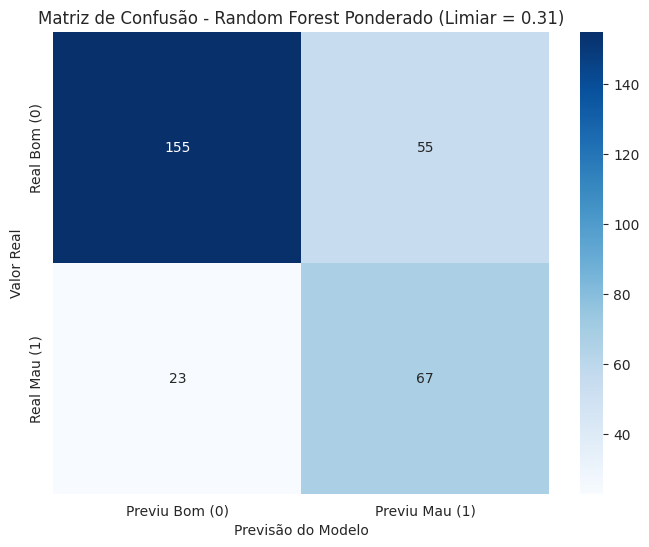

In [8]:
# --- Otimização de Limiar para Random Forest Ponderado ---
print("\n===== Otimização de Limiar para Random Forest Ponderado =====")
# Recuperar o modelo Random Forest Ponderado
model_rf_weighted = models['Random Forest Weighted']
# Definir uma faixa de limiares para otimizar
thresholds_to_test = np.arange(0.25, 0.55, 0.02)  # De 0.25 a 0.55 em passos de 0.02

# Executar a otimização
best_thresh, min_cost, metrics = optimize_threshold_for_cost(
    model_rf_weighted, 
    X_test, 
    y_test, 
    thresholds_to_test, 
    'Random Forest Ponderado'
)

# Adicionar o resultado à tabela final
if min_cost is not None:
    auc_value = [r['AUC-ROC'] for r in results if r['Modelo'] == 'Random Forest Weighted'][0]
    results.append({
        'Modelo': f'RF Ponderado (Limiar Otimizado)',
        'Acurácia': metrics['accuracy'],
        'Custo Total': min_cost,
        'AUC-ROC': auc_value 
    })


===== Ajuste de Hiperparâmetros (Random Forest) =====
Melhores parâmetros: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

===== Relatório de Desempenho do Random Forest Otimizado =====
Acurácia: 75.67%

Relatório de Classificação:
               precision    recall  f1-score   support

Bom Risco (0)       0.77      0.92      0.84       210
Mau Risco (1)       0.67      0.37      0.47        90

     accuracy                           0.76       300
    macro avg       0.72      0.65      0.66       300
 weighted avg       0.74      0.76      0.73       300



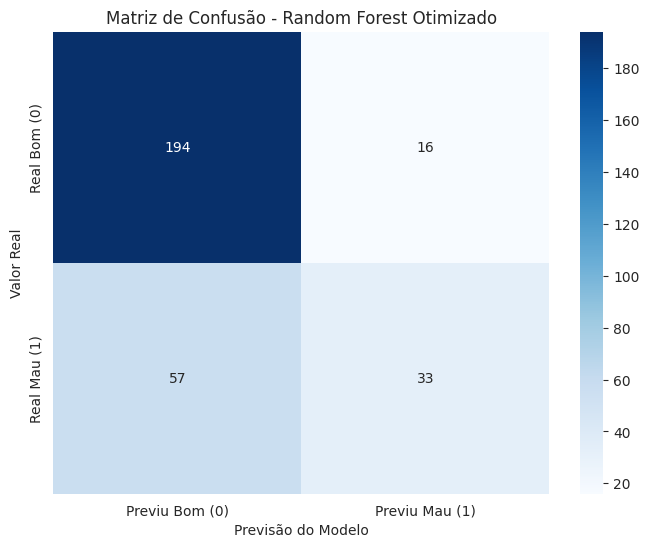

Falsos Negativos (FN): 57, Falsos Positivos (FP): 16, Custo Total: 301


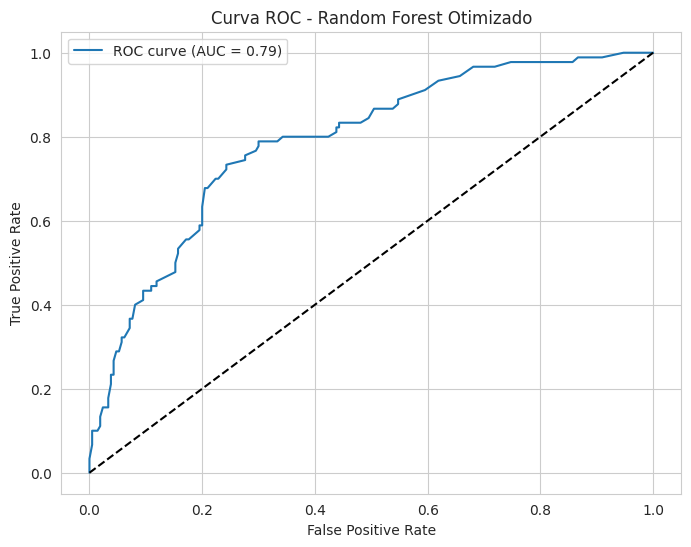

In [9]:
# --- Ajuste de Hiperparâmetros (Random Forest) ---
print("\n===== Ajuste de Hiperparâmetros (Random Forest) =====")
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(
    Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))]),
    param_grid, cv=5, scoring='recall', n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)
y_pred, accuracy, total_cost = train_and_evaluate_model(grid_search.best_estimator_, X_train, X_test, y_train, y_test, 'Random Forest Otimizado')
roc_auc = plot_roc_curve(grid_search.best_estimator_, X_test, y_test, 'Random Forest Otimizado')
results.append({'Modelo': 'Random Forest Otimizado', 'Acurácia': accuracy, 'Custo Total': total_cost, 'AUC-ROC': roc_auc})



===== Importância de Features (Random Forest) =====
                                              Feature  Importance
1                                  num__Credit_Amount    0.113102
0                             num__Duration_in_months    0.086964
3                                            num__Age    0.085521
7    cat__Checking_Account_Status_no checking account    0.060813
2                               num__Installment_Rate    0.043424
4                        num__Present_Residence_Since    0.039179
6         cat__Checking_Account_Status_less than 0 DM    0.036114
38                  cat__Other_Installment_Plans_none    0.027547
23         cat__Saving_Account_Bonds_less than 100 DM    0.027502
9   cat__Credit_History_critical account/other cre...    0.022318


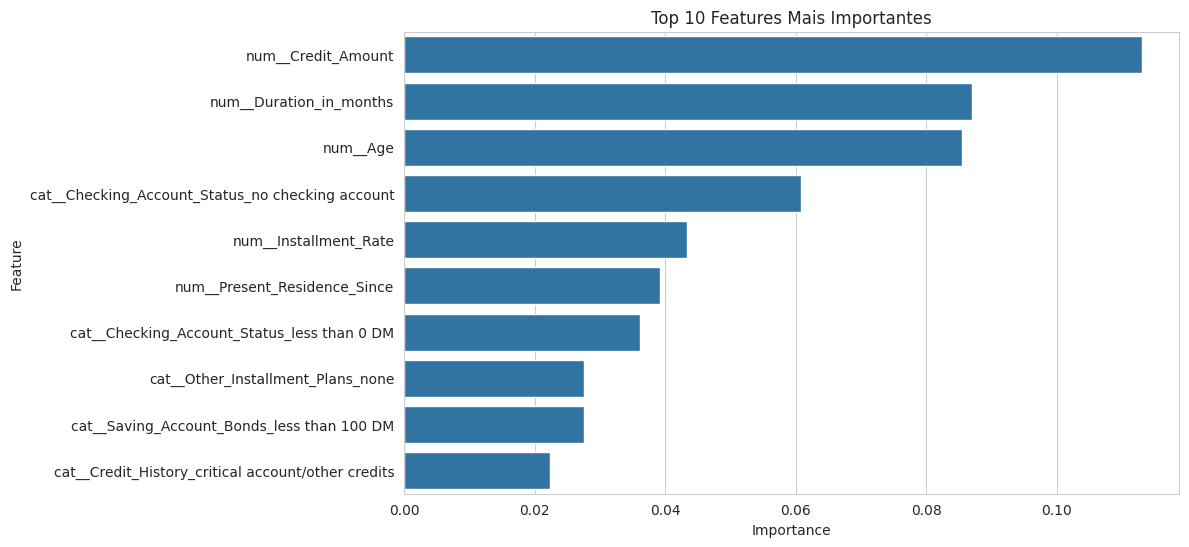

In [10]:
# --- Importância de Features ---
print("\n===== Importância de Features (Random Forest) =====")
model_rf = models['Random Forest']
model_rf.fit(X_train, y_train)  # Treinar o pipeline completo
importances = model_rf.named_steps['classifier'].feature_importances_
feature_names = model_rf.named_steps['preprocessor'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
print(feature_importance_df)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Top 10 Features Mais Importantes')
plt.show()

In [11]:
# --- Resumo de Resultados ---
print("\n===== Resumo de Resultados =====")
results_df = pd.DataFrame(results).sort_values(by='Custo Total', ascending=True)
print(results_df)

# --- Salvamento do Melhor Modelo ---
joblib.dump(grid_search.best_estimator_, 'best_random_forest_model.pkl')
print("\nMelhor modelo salvo como 'best_random_forest_model.pkl'")


===== Resumo de Resultados =====
                            Modelo  Acurácia  Custo Total   AUC-ROC
5  RF Ponderado (Limiar Otimizado)  0.740000          170  0.794418
0              Logistic Regression  0.783333          233  0.802646
3                          XGBoost  0.726667          262  0.777566
4              Random Forest SMOTE  0.766667          270  0.786296
1                    Random Forest  0.756667          293  0.786852
2           Random Forest Weighted  0.760000          296  0.794418
6          Random Forest Otimizado  0.756667          301  0.789180

Melhor modelo salvo como 'best_random_forest_model.pkl'
